# Simulate force profiles for a blue-detuned MOT for CaOH

In [1]:
using Revise

In [2]:
# Import the packages required for the notebook
using
    QuantumStates,
    OpticalBlochEquations,
    DifferentialEquations,
    UnitsToValue

# A few constants used for the simulation
λ = 626e-9
Γ = 2π * 6.4e6 # in units of MHz
m = @with_unit 57 "u"
k = 2π / λ

# Create a few functions to perform random sampling of position and direction
using Distributions
uniform_dist = Uniform(0, 2π)
function sample_direction(r=1.0)
    θ = 2π * rand()
    z = rand() * 2 - 1
    return (r * sqrt(1 - z^2) * cos(θ), r * sqrt(1 - z^2) * sin(θ), r * z)
end
;

┌ Info: Precompiling OpticalBlochEquations [691d0331-80d3-41b1-b293-7891a6f4a14f]
└ @ Base loading.jl:1662


## Load $\tilde{X}(000)$ and $\tilde{A}(000)$ Hamiltonians


In [3]:
HX = load_from_file("CaOH_000_N0to3_Hamiltonian", "..\\..\\..\\QuantumStates\\Hamiltonians\\CaOH\\")
HA = load_from_file("CaOH_A000_J12to52_Hamiltonian", "..\\..\\..\\QuantumStates\\Hamiltonians\\CaOH\\")

# Add Zeeman term to the X state Hamiltonian
const _μB = (μ_B / h) * (1e-6 * 1e-4)
Zeeman_z(state, state′) = Zeeman(state, state′, 0)
HX = add_to_H(HX, :B_z, gS * _μB * Zeeman_z)
HX.parameters.B_z = 1e-6

full_evaluate!(HX); QuantumStates.solve!(HX)
full_evaluate!(HA); QuantumStates.solve!(HA)

HA_J12_pos_parity_states = HA.states[5:8]

# Convert A states from Hund's case (a) to case (b) 
# We'll use the bending mode Hamiltonian for CaOH which has all basis states needed for the conversion
HX_0110 = load_from_file("CaOH_BendingMode_Hamiltonian", "..\\..\\..\\QuantumStates\\Hamiltonians\\CaOH\\")
states_A_J12_caseB = convert_basis(HA_J12_pos_parity_states, HX_0110.basis)
basis_idxs, reduced_A_J12_caseB_basis = states_to_basis(states_A_J12_caseB)
full_basis = [HX.basis; reduced_A_J12_caseB_basis]

for i ∈ eachindex(states_A_J12_caseB)
    states_A_J12_caseB[i].coeffs = states_A_J12_caseB[i].coeffs[basis_idxs]
    states_A_J12_caseB[i].basis = reduced_A_J12_caseB_basis
end

states = [HX.states[5:16]; states_A_J12_caseB]
for state ∈ states
    state.E *= 1e6
end
;

## Zeeman plot for the $X^2\Sigma^+(N=1)$ state in CaOH

In [444]:
function H_func!(H, scan_values)
    H.parameters.B_z = scan_values[1]
    evaluate!(H)
    QuantumStates.solve!(H)
    for i ∈ eachindex(H.states)
        H.states[i].E *= 1e6
    end
    return nothing
end
;

In [445]:
Bs = (-20:0.1:20) #.+ 1e-3
scan_params = (
    B_z = Bs,
    );
iterator = Iterators.product
@time scan_values, tracked_idxs = scan_parameters(HX, scan_params, iterator, H_func!, H -> energy.(H.states), n_threads=1)
;

  0.667085 seconds (292.60 k allocations: 136.549 MiB, 27.56% compilation time)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


In [446]:
using Plots
scan_matrix = hcat(values(scan_values)...)'

plot(Bs, scan_matrix[:,5:16], legend=nothing)
hline!([
        energy(states[1]) - δJ12 / 2π
        energy(states[5]) - δJ32 / 2π
        ],
    linestyle=:dash,
    color=:blue
    )
hline!([
        # energy(states[1]) - δJ12_blue / 2π
        energy(states[5]) - δJ32_blue / 2π
        ],
    linestyle=:dash,
    color=:red
    )
plot!(
    # xlim=(-100.,100.),
    size=(900,600)
)

LoadError: UndefVarError: δJ32_blue not defined

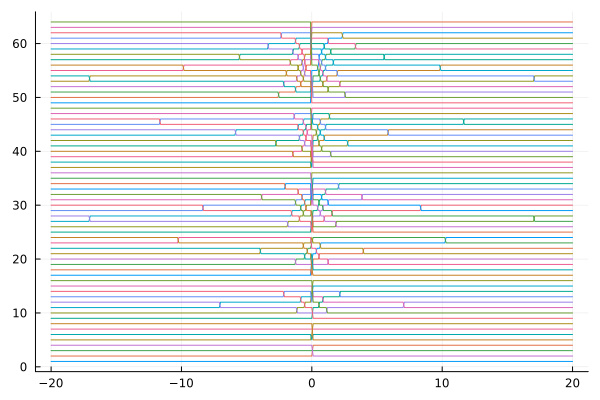

In [64]:
plot(Bs, hcat(values(tracked_idxs)...)', legend=nothing)

In [65]:
function g_factor(H)
    ΔB = 1e-6
    
    evaluate!(H)
    QuantumStates.solve!(H)
    bare_energies = energy.(H.states)
    
    H.parameters.B_z += ΔB
    evaluate!(H)
    QuantumStates.solve!(H)
    B_energies = energy.(H.states)

    # `H` needs to be "reset" for the next calculation
    H.parameters.B_z -= ΔB
    
    return (B_energies .- bare_energies) ./ ΔB
end

g_factor (generic function with 1 method)

In [66]:
Bs = 0:0.01:40
scan_values = (
    B_z = Bs,
    );
iterator = Iterators.product
@time x = scan_parameters(deepcopy(HX_N1), scan_values, iterator, H_func!, g_factor, n_threads=1)
;

LoadError: UndefVarError: HX_N1 not defined

In [67]:
plot(Bs, hcat(values(x)...)', legend=nothing, size=(1000,600))
vline!([3])

LoadError: Expects 4001 elements in each col of y, found 401.

## Set parameters

In [222]:
d = zeros(ComplexF64, 16, 16, 3)
d_ge = zeros(ComplexF64, 12, 4, 3)
basis_tdms = get_tdms_two_bases(HX.basis, reduced_A_J12_caseB_basis, TDM)
tdms_between_states!(d_ge, basis_tdms, HX.states[5:16], states_A_J12_caseB)
d[1:12, 13:16, :] .= d_ge
;

In [502]:
# Laser parameters
J12_energy = energy(states[1])
J32_energy = energy(states[5])
A_energy = energy(states[13])

# CaOH MOT settings
I_load = 32 / 2 # mW/cm^2, or 33 mW per beam of 1/e² diameter = 1 cm (divide by 2 to account for power split between SR frequencies)
I_ramped = I_load / 11 # after ramping down the MOT
Isat = π * h * c * (Γ/2π) / (3λ^3)

s_J12 = I_load / Isat
s_J32 = I_load / Isat
s_J12_blue = s_J12
s_J32_blue = s_J32

# Red-detuned
# δJ12 = -Γ # -1.0Γ
# δJ32 = -Γ # -1.0Γ
# δJ12_blue = +2.0Γ
# δJ32_blue = +2.0Γ
# pol_J12 = σ⁻ # σ⁺
# pol_J32 = σ⁺ # σ⁻
# pol_J12_blue = σ⁺ # σ⁻
# pol_J32_blue = σ⁻ # σ⁺

# Two-frequency settings
s_J12 = 3.0
s_J32 = 1.0
s_J12_red = 3.0
s_J32_red = 3.0
δJ12 = +2.0Γ
δJ32 = +1.0Γ
δJ12_red = -2.0Γ
δJ32_red = -2.0Γ
pol_J12 = σ⁺
pol_J32 = σ⁻
pol_J12_red = σ⁻
pol_J32_red = σ⁺

# Three-frequency settings
# s_J12 = 5.0
# s_J32 = 5.0
# s_J12_red = 2.0
# s_J32_red = 5.0
# δJ12 = +3.0Γ
# δJ32 = +3.0Γ
# δJ12_red = -2.0Γ
# δJ32_red = -4.0Γ
# pol_J12 = σ⁺
# pol_J32 = σ⁻
# pol_J12_red = σ⁻
# pol_J32_red = σ⁺

ω_J12 = 2π * (A_energy - J12_energy) + δJ12
ω_J32 = 2π * (A_energy - J32_energy) + δJ32

ω_J12_red = 2π * (A_energy - J12_energy) + δJ12_red
ω_J32_red = 2π * (A_energy - J32_energy) + δJ32_red

ϵ(ϵ1) = t -> ϵ1

ϵ1 = ϵ( rotate_pol(pol_J12, +x̂)); laser1 = Field(+x̂, ϵ1, ω_J12, s_J12)
ϵ2 = ϵ(-rotate_pol(pol_J12, -x̂)); laser2 = Field(-x̂, ϵ2, ω_J12, s_J12)
ϵ3 = ϵ( rotate_pol(pol_J12, +ŷ)); laser3 = Field(+ŷ, ϵ3, ω_J12, s_J12)
ϵ4 = ϵ(-rotate_pol(pol_J12, -ŷ)); laser4 = Field(-ŷ, ϵ4, ω_J12, s_J12)
ϵ5 = ϵ( rotate_pol(pol_J12, +ẑ)); laser5 = Field(+ẑ, ϵ5, ω_J12, s_J12)
ϵ6 = ϵ( rotate_pol(pol_J12, -ẑ)); laser6 = Field(-ẑ, ϵ6, ω_J12, s_J12)
lasers_J12 = [laser1, laser2, laser3, laser4, laser5, laser6]

ϵ7  = ϵ( rotate_pol(pol_J32, +x̂)); laser7  = Field(+x̂, ϵ7,  ω_J32, s_J32)
ϵ8  = ϵ(-rotate_pol(pol_J32, -x̂)); laser8  = Field(-x̂, ϵ8,  ω_J32, s_J32)
ϵ9  = ϵ( rotate_pol(pol_J32, +ŷ)); laser9  = Field(+ŷ, ϵ9,  ω_J32, s_J32)
ϵ10 = ϵ(-rotate_pol(pol_J32, -ŷ)); laser10 = Field(-ŷ, ϵ10, ω_J32, s_J32)
ϵ11 = ϵ( rotate_pol(pol_J32, +ẑ)); laser11 = Field(+ẑ, ϵ11, ω_J32, s_J32)
ϵ12 = ϵ( rotate_pol(pol_J32, -ẑ)); laser12 = Field(-ẑ, ϵ12, ω_J32, s_J32)
lasers_J32 = [laser7, laser8, laser9, laser10, laser11, laser12]

ϵ13 = ϵ( rotate_pol(pol_J12_red, +x̂)); laser13 = Field(+x̂, ϵ13, ω_J12_red, s_J12_red)
ϵ14 = ϵ(-rotate_pol(pol_J12_red, -x̂)); laser14 = Field(-x̂, ϵ14, ω_J12_red, s_J12_red)
ϵ15 = ϵ( rotate_pol(pol_J12_red, +ŷ)); laser15 = Field(+ŷ, ϵ15, ω_J12_red, s_J12_red)
ϵ16 = ϵ(-rotate_pol(pol_J12_red, -ŷ)); laser16 = Field(-ŷ, ϵ16, ω_J12_red, s_J12_red)
ϵ17 = ϵ( rotate_pol(pol_J12_red, +ẑ)); laser17 = Field(+ẑ, ϵ17, ω_J12_red, s_J12_red)
ϵ18 = ϵ( rotate_pol(pol_J12_red, -ẑ)); laser18 = Field(-ẑ, ϵ18, ω_J12_red, s_J12_red)
lasers_J12_red = [laser13, laser14, laser15, laser16, laser17, laser18]

ϵ19 = ϵ( rotate_pol(pol_J32_red, +x̂)); laser19 = Field(+x̂, ϵ19, ω_J32_red, s_J32_red)
ϵ20 = ϵ(-rotate_pol(pol_J32_red, -x̂)); laser20 = Field(-x̂, ϵ20, ω_J32_red, s_J32_red)
ϵ21 = ϵ( rotate_pol(pol_J32_red, +ŷ)); laser21 = Field(+ŷ, ϵ21, ω_J32_red, s_J32_red)
ϵ22 = ϵ(-rotate_pol(pol_J32_red, -ŷ)); laser22 = Field(-ŷ, ϵ22, ω_J32_red, s_J32_red)
ϵ23 = ϵ( rotate_pol(pol_J32_red, +ẑ)); laser23 = Field(+ẑ, ϵ23, ω_J32_red, s_J32_red)
ϵ24 = ϵ( rotate_pol(pol_J32_red, -ẑ)); laser24 = Field(-ẑ, ϵ24, ω_J32_red, s_J32_red)
lasers_J32_red = [laser19, laser20, laser21, laser22, laser23, laser24]

# lasers = [lasers_J12; lasers_J32]
# lasers = [lasers_J12; lasers_J32; lasers_J12_red]
lasers = [lasers_J12; lasers_J32; lasers_J32_red]
# lasers = [lasers_J12; lasers_J32; lasers_J12_red; lasers_J32_red]
;

In [503]:
# Set initial conditions
particle = Particle()
particle.r0 = (0.0, 0.0, 0.0)
particle.v = (0.0, 0.0, 0.0)

ρ0 = zeros(ComplexF64, length(states), length(states)) # Use a static array for this??? Might be better...
ρ0[1,1] = 1.0

extra_p = (basis_tdms=basis_tdms, HX=HX, d_ge=d_ge)
freq_res = 1e-2
p = obe(ρ0, particle, states, lasers, d, d, true, true, λ, Γ, freq_res, extra_p)

p.B = (0., 0., 0.) ./ (Γ / (_μB * 1e6))
p.r0 = (0., 0., 0.) .* 2π
p.v = (0., 0., 0.5) ./ (Γ / k)
p.v = round_vel(p.v, p.freq_res)
;

In [504]:
# using BenchmarkTools
# dρ = deepcopy(ρ0)
# @time ρ!(dρ, ρ0, p, 0.0)
# @btime ρ!($dρ, $ρ0, $p, 0.0)

In [505]:
t_end = 50p.period+1
tspan = (0., t_end)
prob = ODEProblem(ρ!, p.ρ0_vec, tspan, p)
;

In [506]:
prob.p.force_last_period = (0, 0, 0)
cb = PeriodicCallback(reset_force!, p.period)
@time sol = DifferentialEquations.solve(prob, DP5(), callback=cb, abstol=1e-5)
;

  8.402754 seconds (15.69 M allocations: 1.956 GiB, 7.27% gc time, 97.60% compilation time)


In [507]:
sol.t[end], t_end

(1884.9555921538758, 31416.926535897932)

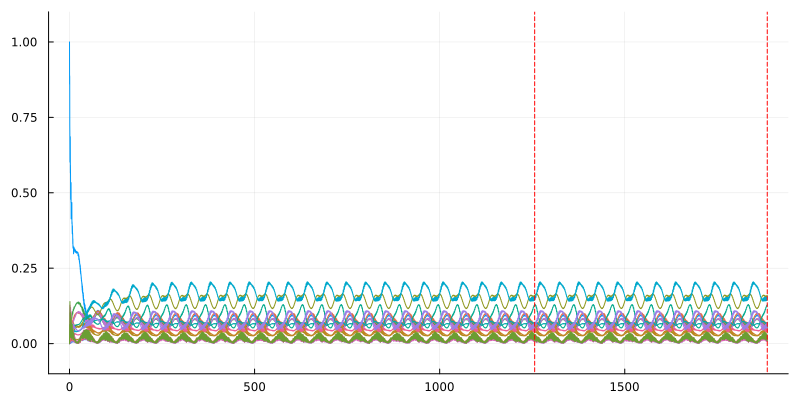

In [508]:
using Plots
plot_us = sol.u
plot_ts = sol.t

n_states = size(p.ρ_soa, 1)
plot(size=(800, 400), ylim=(-0.1, 1.1), legend=nothing)
for i in 1:n_states
    state_idx = n_states*(i-1) + i
    plot!(plot_ts, [real(u[state_idx]) for u in plot_us])
end
plot!()
offset = 0
vline!([sol.t[end] - p.period - offset, sol.t[end] - offset], color="red", linestyle=:dash)
# vline!([280, 380], color="red", linestyle=:dash)

In [357]:
prob.p.force_last_period * (1e-3 * ħ * k * Γ / m)

3-element StaticArraysCore.SVector{3, Float64} with indices SOneTo(3):
  2.3162941249864662e-12
  2.3156165114806047e-12
 -7.710171668189461

In [358]:
prob.p.populations

16-element Vector{ComplexF64}:
  0.08607754051538284 + 0.0im
  0.08782507026024579 + 0.0im
  0.08979403735101552 + 0.0im
  0.08364201594562531 + 0.0im
  0.05525841004988376 + 0.0im
  0.10155487526932577 + 0.0im
  0.07850125528124267 + 0.0im
  0.03889811060211526 + 0.0im
  0.06412218199493626 + 0.0im
  0.08764913869119575 + 0.0im
  0.10144503286740532 + 0.0im
   0.0691476637516216 + 0.0im
 0.012863375425735731 + 0.0im
 0.015178958019593505 + 0.0im
 0.012123026776852263 + 0.0im
 0.015919307197817423 + 0.0im

## Force versus velocity

In [517]:
function prob_func!(prob, scan_values, i)
    # Update velocity and position
    prob.p.v .= (0, 0, scan_values.v[i]) #sample_direction(scan_values.v[i]) # (0, 0, scan_values.v[i])
    prob.p.v .= round_vel(prob.p.v, prob.p.freq_res)    
    prob.p.r0 .= rand(uniform_dist, 3)
    return prob
end
function param_func(prob, scan_values, i)
    return scan_values.v[i]
end
function output_func(p, sol)
    f = p.force_last_period
    f_proj = (f ⋅ p.v) / norm(p.v)
    return isnan(f_proj) ? 0.0 : f_proj
end
;

In [518]:
freq_res = 1e-2
p = obe(ρ0, particle, states, lasers, d, d, true, true, λ, Γ, freq_res)

t_end = 20p.period+1; tspan = (0., t_end)
prob = ODEProblem(ρ!, p.ρ0_vec, tspan, p, abstol=1e-5, save_on=false)

n_samples = 100

prob.p.B .= (0.0, 0.0, 0.0)
# vs = repeat([collect(0:0.2:2.0); collect(2.2:0.3:4.5); collect(5:1:10)], n_samples) ./ (Γ / k)
vs = repeat([collect(0:0.01:0.1); collect(0.2:0.1:1.0); [2.0, 2.5, 3.0]], n_samples) ./ (Γ / k)
# vs = repeat(0:0.25:5, n_samples) ./ (Γ / k)

scan_values = (v = vs,)
;

Progress: 100%|█████████████████████████████████████████| Time: 0:00:33


 33.603662 seconds (754.60 k allocations: 291.778 MiB, 0.75% compilation time: 83% of which was recompilation)


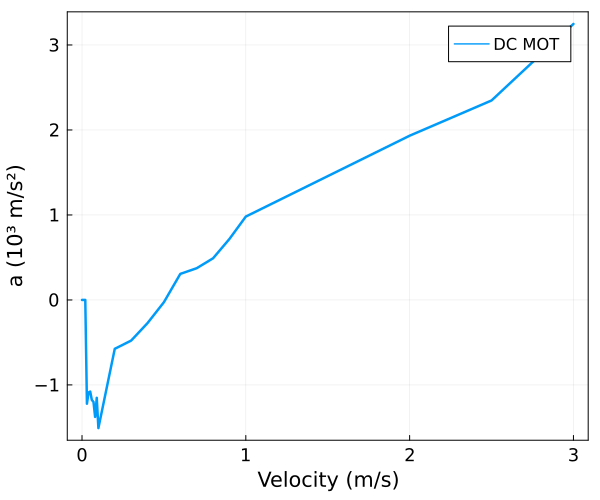

In [519]:
@time scan_params, forces, populations_velocity = force_scan(prob, scan_values, prob_func!, param_func, output_func);
vs, averaged_forces_velocity = average_values(scan_params, forces)
averaged_forces_velocity[1] = 0.0
plot(vs .* (Γ / k), (1e-3 * ħ * k * Γ / m) .* averaged_forces_velocity,
    xlabel="Velocity (m/s)",
    ylabel="a (10³ m/s²)",
    framestyle=:box,
    linewidth=2.5,
    labelfontsize=14,
    tickfont=12,
    legendfont=11,
    # ylim=(-8,6),
    label="DC MOT",
    size=(600,500)
    )

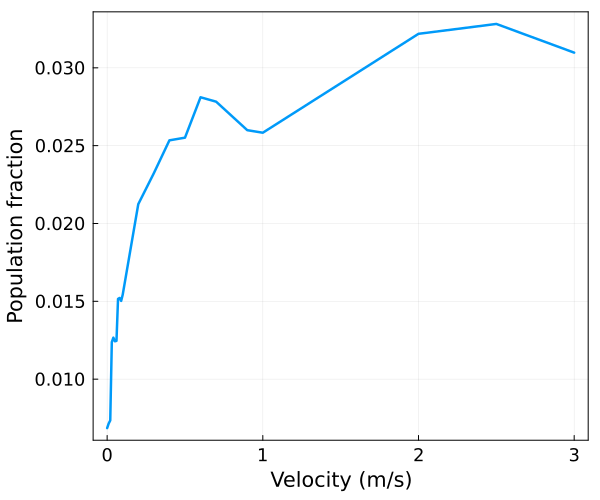

In [287]:
vs, averaged_populations_velocity = average_values(scan_params, populations_velocity)
plot(vs .* (Γ / k), sum(averaged_populations_velocity[:,13:16], dims=2),
    xlabel="Velocity (m/s)",
    ylabel="Population fraction",
    framestyle=:box,
    linewidth=2.5,
    labelfontsize=14,
    tickfont=12,
    legendfont=11,
    legend=nothing,
    size=(600,500)
    )

Progress: 100%|█████████████████████████████████████████| Time: 0:00:43


 43.573049 seconds (16.85 M allocations: 2.121 GiB, 1.20% gc time, 22.77% compilation time)


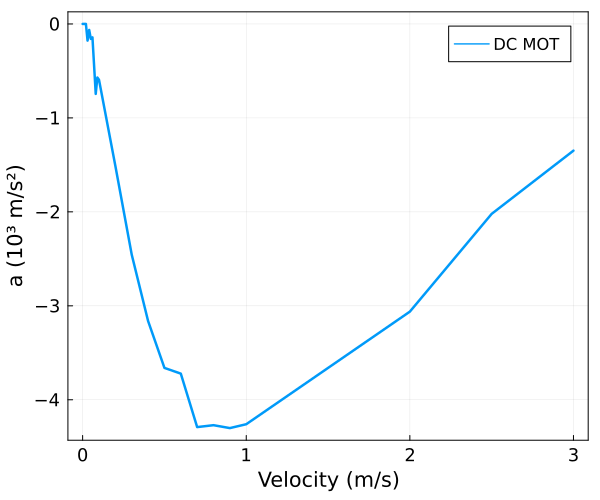

In [306]:
# Three frequencies
@time scan_params, forces_3, populations_velocity_3 = force_scan(prob, scan_values, prob_func!, param_func, output_func);
vs, averaged_forces_velocity_3 = average_values(scan_params, forces_3)
averaged_forces_velocity[1] = 0.0
plot(vs .* (Γ / k), (1e-3 * ħ * k * Γ / m) .* averaged_forces_velocity_3,
    xlabel="Velocity (m/s)",
    ylabel="a (10³ m/s²)",
    framestyle=:box,
    linewidth=2.5,
    labelfontsize=14,
    tickfont=12,
    legendfont=11,
    # ylim=(-8,6),
    label="DC MOT",
    size=(600,500)
    )

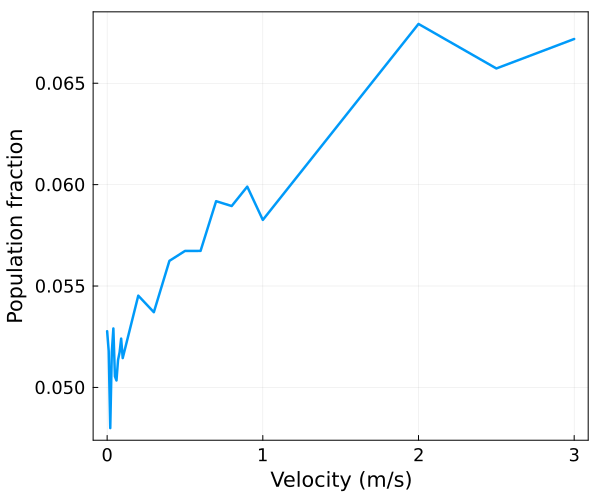

In [307]:
vs, averaged_populations_velocity_3 = average_values(scan_params, populations_velocity_3)
plot(vs .* (Γ / k), sum(averaged_populations_velocity_3[:,13:16], dims=2),
    xlabel="Velocity (m/s)",
    ylabel="Population fraction",
    framestyle=:box,
    linewidth=2.5,
    labelfontsize=14,
    tickfont=12,
    legendfont=11,
    legend=nothing,
    size=(600,500)
    )

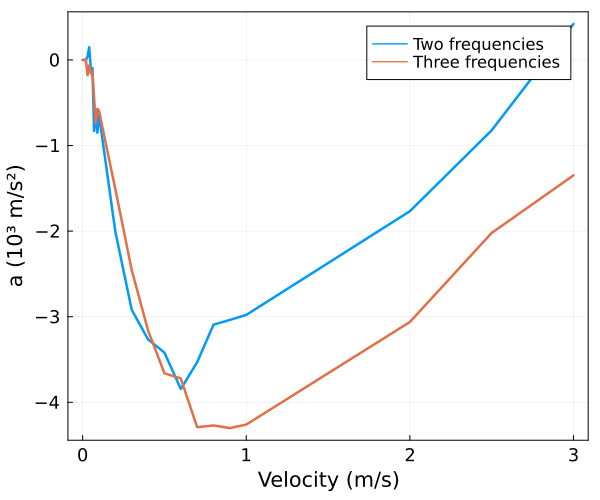

In [324]:
# All frequencies
plot(vs .* (Γ / k), (1e-3 * ħ * k * Γ / m) .* averaged_forces_velocity,
    xlabel="Velocity (m/s)",
    ylabel="a (10³ m/s²)",
    framestyle=:box,
    linewidth=2.5,
    labelfontsize=14,
    tickfont=12,
    legendfont=11,
    # ylim=(-8,6),
    label="Two frequencies",
    size=(600,500)
    )
plot!(vs .* (Γ / k), (1e-3 * ħ * k * Γ / m) .* averaged_forces_velocity_3,
    xlabel="Velocity (m/s)",
    ylabel="a (10³ m/s²)",
    linewidth=2.5,
    label="Three frequencies",
    size=(600,500)
    )

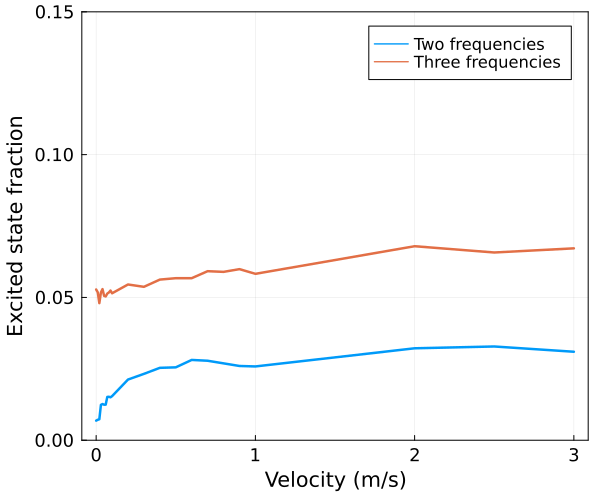

In [332]:
plot(vs .* (Γ / k), sum(averaged_populations_velocity[:,13:16], dims=2),
    xlabel="Velocity (m/s)",
    ylabel="Excited state fraction",
    framestyle=:box,
    linewidth=2.5,
    labelfontsize=14,
    tickfont=12,
    legendfont=11,
    label="Two frequencies",
    size=(600,500)
    )
plot!(vs .* (Γ / k), sum(averaged_populations_velocity_3[:,13:16], dims=2),
    xlabel="Velocity (m/s)",
    ylabel="Excited state fraction",
    linewidth=2.5,
    ylim=(0,0.15),
    label="Three frequencies"
    )

## Force versus magnetic field

In [521]:
function prob_func!(prob, scan_values, i)
    p = prob.p

    # Solve Hamiltonian for new `Bz` value (this is expensive, so only do it if the value has changed)
    Bz = scan_values.Bz[i] .* (p.Γ / (_μB * 1e6))
    
    if p.extra_p.HX.parameters.B_z != Bz
        
        # Solve X state Hamiltonian for new B_z value
        p.extra_p.HX.parameters.B_z = Bz 
        evaluate!(p.extra_p.HX)
        QuantumStates.solve!(p.extra_p.HX)
        for i ∈ eachindex(p.extra_p.HX.states)
            p.extra_p.HX.states[i].E *= 1e6
        end
        
        # Solve A state Hamiltonian for new B_z value
        # p.extra_p.HA_J12.parameters.B_z = 0. #Bz
        # evaluate!(p.extra_p.HA_J12)
        # QuantumStates.solve!(p.extra_p.HA_J12)
        # for i ∈ eachindex(p.extra_p.HA_J12.states)
        #     p.extra_p.HA_J12.states[i].E *= 1e6
        # end
        # J12_positive_parity = p.extra_p.HA_J12.states[5:8]
        # J12_positive_parity_caseB = convert_basis(J12_positive_parity, p.extra_p.reduced_A_J12_caseB_basis)
        
        # Update TDMs
        tdms_between_states!(p.extra_p.d_ge, p.extra_p.basis_tdms, p.extra_p.HX.states[5:16], p.extra_p.states_A_J12_caseB)
        p.d[1:12, 13:16, :] .= p.extra_p.d_ge
        
        states′ = [p.extra_p.HX.states[5:16]; p.extra_p.states_A_J12_caseB]

        extra_p = (
            basis_tdms=p.extra_p.basis_tdms, 
            HX=p.extra_p.HX, 
            d_ge=p.extra_p.d_ge, 
            reduced_A_J12_caseB_basis=p.extra_p.reduced_A_J12_caseB_basis, 
            states_A_J12_caseB=p.extra_p.states_A_J12_caseB)
        new_p = obe(
            p.ρ0, p.particle, states′, p.fields, p.d, p.d, true, true, p.λ, p.Γ, p.freq_res, extra_p
        )
    else
        new_p = p
    end
    
    # Update velocity, position, and "reset" the frequencies of the lasers
    # (Technically, we're only overwriting the laser frequencies in `new_p` here because `obe` changes them when there's no need to 
    # -- will need to shore up how this is handled.)
    new_p.v .= sample_direction(0.1) # ./ (p.Γ / p.k)
    new_p.r0 .= rand(uniform_dist, 3)
    new_p.fields.ω .= p.fields.ω
    
    # Ensure that frequencies and velocities are rounded
    round_params(new_p)
    
    return remake(prob, p=new_p)
end
function param_func(prob, scan_values, i)
    return scan_values.Bz[i]
end
function output_func(p, sol)
    f = p.force_last_period
    return f[3] #(f ⋅ p.v) / norm(p.v)
end
;

In [522]:
freq_res = 1e-1
extra_p = (basis_tdms=basis_tdms, HX=HX, d_ge=d_ge, reduced_A_J12_caseB_basis=reduced_A_J12_caseB_basis, states_A_J12_caseB=states_A_J12_caseB)
p = obe(ρ0, particle, states, lasers, d, d, true, true, λ, Γ, freq_res, extra_p)

t_end = 50p.period+1; tspan = (0., t_end)
prob = ODEProblem(ρ!, p.ρ0_vec, tspan, p, abstol=1e-5, save_on=false)

Bzs = (0:1:25) ./ (Γ / (_μB * 1e6))
# rs = vec([[rx, ry, rz] for rx in (0:1/16:0.95), ry in (0:1/16:0.95), rz in (0:1/16:0.95)])
# vs = [0.0]
# iterator = Iterators.product(Bzs, rs, vs)

n_samples = 1000

scan_values = (Bz = repeat(Bzs, n_samples),)
;

Progress: 100%|█████████████████████████████████████████| Time: 0:01:258:57


 85.249759 seconds (33.38 M allocations: 15.203 GiB, 6.66% gc time, 13.40% compilation time)


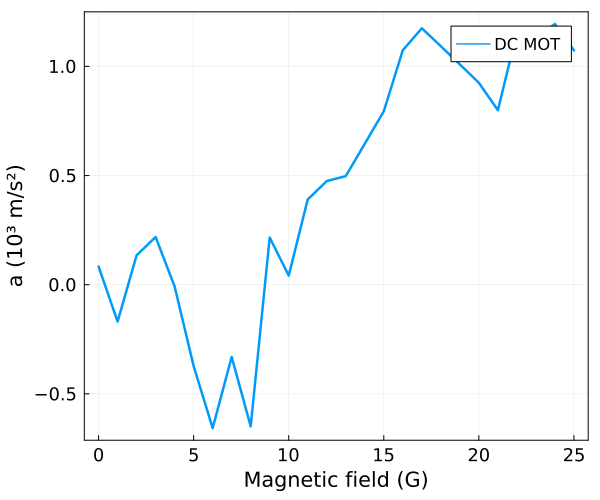

In [470]:
@time scan_params, forces_magnetic, populations_magnetic = force_scan(prob, scan_values, prob_func!, param_func, output_func)
Bzs, averaged_forces_magnetic = average_values(scan_params, forces_magnetic)
plot(Bzs .* (Γ / (_μB * 1e6)), (1e-3 * ħ * k * Γ / m) .* averaged_forces_magnetic, 
    xlabel="Magnetic field (G)",
    ylabel="a (10³ m/s²)",
    framestyle=:box,
    linewidth=2.5,
    labelfontsize=14,
    tickfont=12,
    legendfont=11,
    # xlim=(0,10),
    # ylim=(-3,0),
    label="DC MOT",
    size=(600,500)
    )

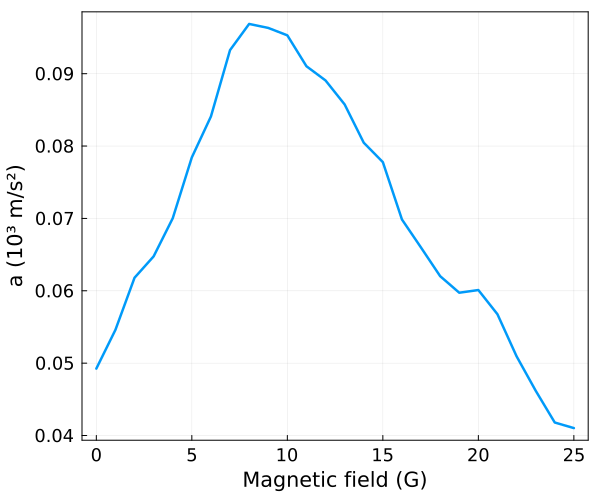

In [457]:
Bzs, averaged_populations_magnetic = average_values(scan_params, populations_magnetic)
plot(Bzs .* (Γ / (_μB * 1e6)), sum(averaged_populations_magnetic[:,13:16], dims=2), 
    xlabel="Magnetic field (G)",
    ylabel="a (10³ m/s²)",
    framestyle=:box,
    linewidth=2.5,
    labelfontsize=14,
    tickfont=12,
    legendfont=11,
    # xlim=(0,10),
    # ylim=(-3,0),
    legend=nothing,
    size=(600,500)
    )

Progress: 100%|█████████████████████████████████████████| Time: 0:01:00


 60.844450 seconds (15.74 M allocations: 13.281 GiB, 1.08% compilation time: 100% of which was recompilation)


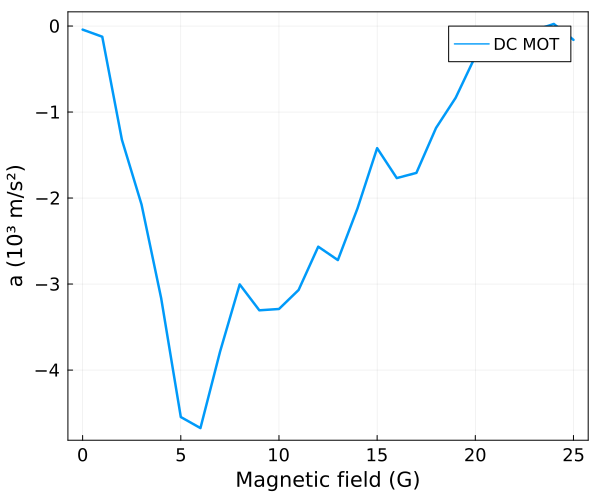

In [523]:
# Three frequencies
@time scan_params, forces_magnetic_3, populations_magnetic_3 = force_scan(prob, scan_values, prob_func!, param_func, output_func)
Bzs, averaged_forces_magnetic_3 = average_values(scan_params, forces_magnetic_3)
plot(Bzs .* (Γ / (_μB * 1e6)), (1e-3 * ħ * k * Γ / m) .* averaged_forces_magnetic_3, 
    xlabel="Magnetic field (G)",
    ylabel="a (10³ m/s²)",
    framestyle=:box,
    linewidth=2.5,
    labelfontsize=14,
    tickfont=12,
    legendfont=11,
    # xlim=(0,10),
    # ylim=(-3,0),
    label="DC MOT",
    size=(600,500)
    )

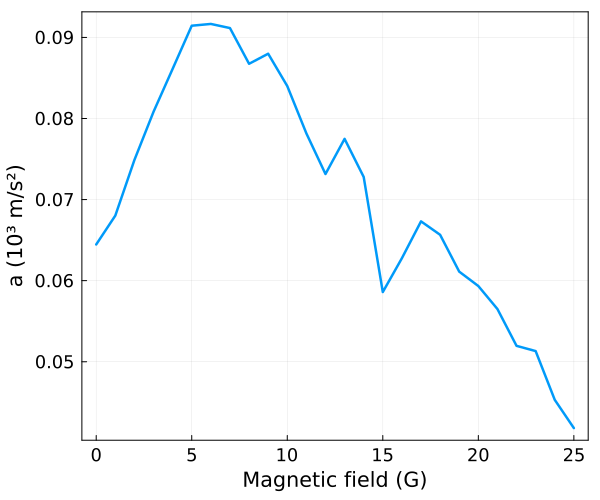

In [526]:
plot(Bzs .* (Γ / (_μB * 1e6)), sum(averaged_populations_magnetic_3[:,13:16], dims=2), 
    xlabel="Magnetic field (G)",
    ylabel="a (10³ m/s²)",
    framestyle=:box,
    linewidth=2.5,
    labelfontsize=14,
    tickfont=12,
    legendfont=11,
    # xlim=(0,10),
    # ylim=(-3,0),
    legend=nothing,
    size=(600,500)
    )

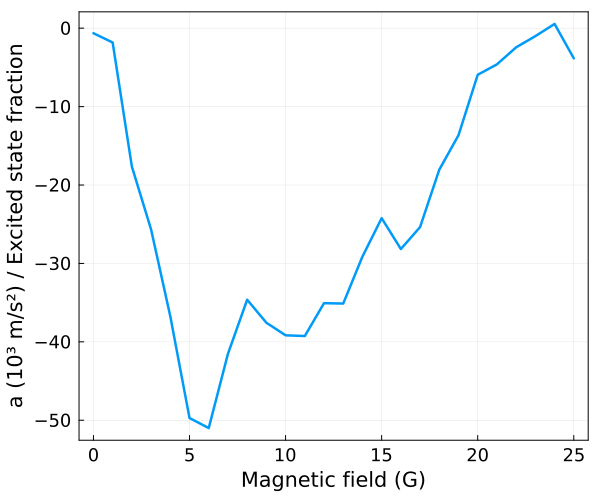

In [527]:
Bzs, averaged_populations_magnetic_3 = average_values(scan_params, populations_magnetic_3)
plot(Bzs .* (Γ / (_μB * 1e6)), (1e-3 * ħ * k * Γ / m) .* averaged_forces_magnetic_3 ./ sum(averaged_populations_magnetic_3[:,13:16], dims=2), 
    xlabel="Magnetic field (G)",
    ylabel="a (10³ m/s²) / Excited state fraction",
    framestyle=:box,
    linewidth=2.5,
    labelfontsize=14,
    tickfont=12,
    legendfont=11,
    # xlim=(0,10),
    # ylim=(-3,0),
    legend=nothing,
    size=(600,500)
    )

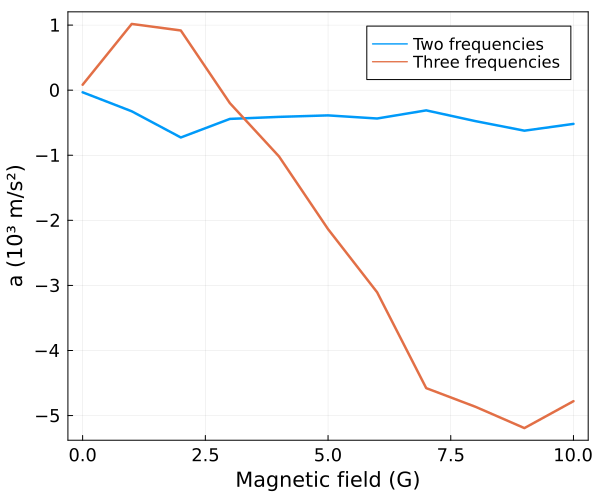

In [313]:
# All frequencies
plot(Bzs .* (Γ / (_μB * 1e6)), (1e-3 * ħ * k * Γ / m) .* averaged_forces_magnetic, 
    xlabel="Magnetic field (G)",
    ylabel="a (10³ m/s²)",
    framestyle=:box,
    linewidth=2.5,
    labelfontsize=14,
    tickfont=12,
    legendfont=11,
    label="Two frequencies",
    size=(600,500)
    )
plot!(Bzs .* (Γ / (_μB * 1e6)), (1e-3 * ħ * k * Γ / m) .* averaged_forces_magnetic_3, 
    xlabel="Magnetic field (G)",
    ylabel="a (10³ m/s²)",
    framestyle=:box,
    linewidth=2.5,
    labelfontsize=14,
    tickfont=12,
    legendfont=11,
    label="Three frequencies",
    size=(600,500)
    )

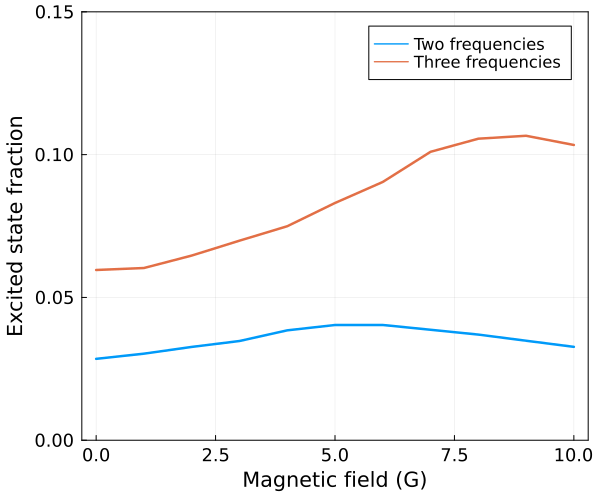

In [320]:
# All frequencies
plot(Bzs .* (Γ / (_μB * 1e6)), sum(averaged_populations_magnetic[:,13:16], dims=2), 
    xlabel="Magnetic field (G)",
    ylabel="Excited state fraction",
    framestyle=:box,
    linewidth=2.5,
    labelfontsize=14,
    tickfont=12,
    legendfont=11,
    ylim=(0,0.15),
    label="Two frequencies",
    size=(600,500)
    )
plot!(Bzs .* (Γ / (_μB * 1e6)), sum(averaged_populations_magnetic_3[:,13:16], dims=2), 
    xlabel="Magnetic field (G)",
    ylabel="Excited state fraction",
    framestyle=:box,
    linewidth=2.5,
    labelfontsize=14,
    tickfont=12,
    legendfont=11,
    label="Three frequencies",
    size=(600,500)
    )